# Indexing Variaton

In [13]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

###########################################
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

import itertools as it



from matplotlib.collections import BrokenBarHCollection
import pandas as pd

import re

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

In previous posts, we resorted to density estimates to attempt to weed out outliers, identify cases of mislabelling and classify unlabelled observations. 

We went on to explore how cluster-derived KDE vectors of the same variables would aggregate in feature space, allowing us to label them in bulk (see **5. Visualizing KDE**).

Varying distances among clusters, resulting distinguishable cluster profiles, can be of interest, depending on the nature of the data we are considering. If those distances vary according to physical distance for example, it might be interesting to extract and visualize those locations.

Let's begin by performing the same simulations, of three populations, of which two see their distributions overlap as a function of a variable X (also seen in **6. Conditional Variation**).

In [47]:

# We must first define the number of populations, the length of the haplotypes desired, and their respective population sizes
L= 300

import itertools as it
n= 20
n_samples= 20

a_range= np.linspace(1.5,2.5,n_samples)
a_set= [i for i in a_range for _ in range(n)]

b_range= np.linspace(0.1,.6,n_samples)
b_set= [i for i in b_range for _ in range(n)]

L_set= [L] * n * n_samples

traces= [x for x in it.product(range(n*11),range(n*11),range(n*11))]

background= np.array([a_set,b_set,L_set]).T

vector_lib= []
for k in range(background.shape[0]):
    
    probs= beta.rvs(background[k,0], background[k,1], size=int(background[k,2]))
    probs[(probs > 1)]= 1
    probs= [1-x for x in probs]
    
    
    vector_lib.append(probs)

vector_lib= np.array(vector_lib)



In [48]:
n_comp = 50

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')
features = pca.fit_transform(vector_lib)

var_comps= pca.explained_variance_ratio_
print("; ".join(['PC{0}: {1}'.format(x+1,round(var_comps[x],3)) for x in range(n_comp)]))
print('features shape: {}'.format(features.shape))

PC1: 0.046; PC2: 0.011; PC3: 0.011; PC4: 0.011; PC5: 0.011; PC6: 0.01; PC7: 0.01; PC8: 0.01; PC9: 0.01; PC10: 0.01; PC11: 0.01; PC12: 0.009; PC13: 0.009; PC14: 0.009; PC15: 0.009; PC16: 0.009; PC17: 0.009; PC18: 0.009; PC19: 0.009; PC20: 0.008; PC21: 0.008; PC22: 0.008; PC23: 0.008; PC24: 0.008; PC25: 0.008; PC26: 0.008; PC27: 0.008; PC28: 0.008; PC29: 0.008; PC30: 0.008; PC31: 0.008; PC32: 0.007; PC33: 0.007; PC34: 0.007; PC35: 0.007; PC36: 0.007; PC37: 0.007; PC38: 0.007; PC39: 0.007; PC40: 0.007; PC41: 0.007; PC42: 0.007; PC43: 0.007; PC44: 0.006; PC45: 0.006; PC46: 0.006; PC47: 0.006; PC48: 0.006; PC49: 0.006; PC50: 0.006
features shape: (400, 50)


In [14]:
#### Let's plot the first 3 coordinates nonetheless.
####
fig_data= [go.Scatter3d(
        x = features[:,0],
        y = features[:,1],
        z = features[:,2],
        type='scatter3d',
        mode= "markers",
        text= ['a: {}; b: {}, L: {}; index = {}'.format(background[k,0],background[k,1],background[k,2], k) for k in range(background.shape[0])],
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      }
    )]


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene= Scene(
    yaxis=dict(
        title='PC2: {}'.format(round(var_comps[1],3))),
    xaxis=dict(
    title= 'PC1: {}'.format(round(var_comps[0],3))),
    zaxis=dict(
    title= 'PC3: {}'.format(round(var_comps[2],3))))
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)


In [15]:
#### calculating Fsts between populations.
Pops= [363,353,375]
Sizes= [80,100,30]

def return_fsts(vector_lib,pops):
    H= {pop: [1-(vector_lib[pop,x]**2 + (1 - vector_lib[pop,x])**2) for x in range(vector_lib.shape[1])] for pop in pops}
    Store= []
    for comb in it.combinations(pops,2):
        P= [sum([vector_lib[x,i] for x in comb]) / len(comb) for i in range(vector_lib.shape[1])]
        HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
        Fst= np.mean([(HT[x] - np.mean([H[p][x] for p in comb])) / HT[x] for x in range(len(P))])
        
        Store.append([comb,Fst])
    
    ### total fst:
    P= [sum([vector_lib[x,i] for x in pops]) / len(pops) for i in range(vector_lib.shape[1])]
    HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
    FST= np.mean([(HT[x] - np.mean([H[p][x] for p in pops])) / HT[x] for x in range(len(P))])
    
    return pd.DataFrame(Store,columns= ['pops','fst']),FST

Pairwise, Total_fst= return_fsts(vector_lib,Pops)

print('global fst: {}'.format(round(Total_fst,4)))
Pairwise

global fst: 0.1389


,pops,fst
0,"(363, 353)",0.092307
1,"(363, 375)",0.107363
2,"(353, 375)",0.094455


We'll now go through the same motions, so that we can attest, through visual analysis, which groups of vectors represent which kinds of clusters.

In [17]:

def extract_profiles(global_data):
    ## estimate the bandwith
    bandwidth = estimate_bandwidth(global_data, quantile=0.2)
    params = {'bandwidth': np.linspace(np.min(global_data), np.max(global_data),20)}
    grid = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params,verbose=0)
    
    ## perform MeanShift clustering.
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True, min_bin_freq=5)
    ms.fit(global_data)
    labels1 = ms.labels_
    label_select = {y:[x for x in range(len(labels1)) if labels1[x] == y] for y in sorted(list(set(labels1)))}

    ## Extract the KDE of each cluster identified by MS.
    cluster_profiles= []

    

    for lab in label_select.keys():
        
        Quanted_set= global_data[label_select[lab],:]

        grid.fit(Quanted_set)

        kde = grid.best_estimator_

        P_dist = kde.score_samples(Quanted_set)
        Fist = kde.score_samples(global_data)

        ## Normalizing log-likelihood estimates by those of the reference set.
        Fist = scipy.stats.norm(np.mean(P_dist),np.std(P_dist)).cdf(Fist)
        cluster_profiles.append(Fist)
    
    return cluster_profiles
    
#### We'll have to first change our fst function.

def return_fsts2(freq_array):
    pops= range(freq_array.shape[0])
    H= {pop: [1-(freq_array[pop,x]**2 + (1 - freq_array[pop,x])**2) for x in range(freq_array.shape[1])] for pop in range(freq_array.shape[0])}
    Store= []

    for comb in it.combinations(H.keys(),2):
        P= [sum([freq_array[x,i] for x in comb]) / len(comb) for i in range(freq_array.shape[1])]
        HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
        per_locus_fst= [[(HT[x] - np.mean([H[p][x] for p in comb])) / HT[x],0][int(HT[x] == 0)] for x in range(len(P))]
        per_locus_fst= np.nan_to_num(per_locus_fst)
        Fst= np.mean(per_locus_fst)

        Store.append([comb,Fst])
    
    
    ### total fst:
    P= [sum([freq_array[x,i] for x in pops]) / len(pops) for i in range(freq_array.shape[1])]
    HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
    FST= np.mean([(HT[x] - np.mean([H[p][x] for p in pops])) / HT[x] for x in range(len(P))])
    
    return pd.DataFrame(Store,columns= ['pops','fst'])


In [18]:
#### We're going to do something different now. We'll have two points get closer together in time.
#first chose two
target= [1,2]


labels= []
Fsts_crawl= []
angle_list= []
Distances_crawl= []

for angle in np.arange(1,30,.1):
    coords= features[Pops,:]
    vector2= coords[target[1]] - coords[target[0]]

    coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    
    new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])
    new_freqs[new_freqs > 1] = 1
    new_freqs[new_freqs < 0] = 0
    
    Pairwise= return_fsts2(new_freqs)
    
    Distances= []
    for train in it.combinations([x for x in range(new_freqs.shape[0])],2):
        Distances.append(np.sqrt((coords[train[0]][0] - coords[train[1]][0])**2 + (coords[train[0]][1] - coords[train[1]][1])**2) + (coords[train[0]][2] - coords[train[1]][2])**2)
    Distances_crawl.extend(Distances)
    
    labels.extend(Pairwise.pops)
    
    Fsts_crawl.extend(Pairwise.fst)
    angle_list.extend([angle] * Pairwise.shape[0])


Control= np.array([angle_list,Fsts_crawl]).T

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning:

invalid value encountered in double_scalars



In [19]:
fig_data= [go.Scatter(
x= Distances_crawl,
y= Fsts_crawl,
mode= 'markers',
name= 'fst vs distances'
)
]

layout = go.Layout(
    title= 'Fst vs. distance in vector feature space',
    yaxis=dict(
        title='fsts'),
    xaxis=dict(
        title='eucledian distance in feature space')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [20]:
coords= {z:[x for x in range(len(labels)) if labels[x] == z] for z in list(set(labels))}

fig_data= [go.Scatter(
x= Control[coords[i],0],
y= Control[coords[i],1],
mode= 'lines',
name= 'fst pops {} / {}'.format(i[0],i[1])
) for i in coords.keys()
]

layout = go.Layout(
    title= 'pairwise Fsts as a function of variable X',
    yaxis=dict(
        title='between population Fst'),
    xaxis=dict(
        title='X')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [21]:
coords= {z:[x for x in range(len(labels)) if labels[x] == z] for z in list(set(labels))}

fig_data= [go.Scatter(
x= [sin(x) for x in Control[coords[i],0]],
y= Control[coords[i],1],
mode= 'lines',
name= 'fst pops {} / {}'.format(i[0],i[1])
) for i in coords.keys()
]

layout = go.Layout(
    title= 'pairwise Fsts against the sinusoid of variable X',
    yaxis=dict(
        title='between population Fst'),
    xaxis=dict(
        title='sin(X)')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [49]:
labels= [0,1,2]

label_vector= np.repeat(np.array([x for x in labels]),Sizes)
label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in labels}

cluster_profiles= []

Windows= []


target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in list(set(label_vector))}
threshold= .005
P= 30


for angle in np.arange(1,30,.1):
    coords= features[Pops,:]
    vector2= coords[target[1]] - coords[target[0]]

    coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    #new_freqs= vector_lib[Pops,:]
    new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])


    N_pops= len(Pops)
    
    labels= np.repeat(np.array([x for x in range(N_pops)]),Sizes)

    data= []

    for k in range(N_pops):

        probs= new_freqs[k,:]
        
        probs[(probs > 1)]= 1
        probs[(probs < 0)]= 0
        m= Sizes[k]
        Haps= [[np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)] for acc in range(m)]

        data.extend(Haps)
    
    data= np.array(data)
    pca2 = PCA(n_components=3, whiten=False,svd_solver='randomized')

    data= pca2.fit_transform(data)

    profiles= extract_profiles(data,)
    
    ### store stuff.
    cluster_profiles.extend(profiles)
    Windows.extend([angle] * len(profiles))


## number of comps to retain
n_comp= 3

pca = PCA(n_components=n_comp, whiten=False).fit(cluster_profiles)
COMPS = pca.transform(cluster_profiles)
X_se = pca.components_.T*np.sqrt(pca.explained_variance_)

print("Variance explained:")
print("; ".join(['PC{0}: {1}'.format(x+1,round(pca.explained_variance_ratio_[x],3)) for x in range(n_comp)]))## stacking our data.


Variance explained:
PC1: 0.482; PC2: 0.17; PC3: 0.022


In [50]:
print(X_se.shape)
print(COMPS.shape)

fig_data= [go.Scatter3d(
        x = X_se[[x for x in range(sum(Sizes)) if label_vector[x] == i],0],
        y = X_se[[x for x in range(sum(Sizes)) if label_vector[x] == i],1],
        z = X_se[[x for x in range(sum(Sizes)) if label_vector[x] == i],2],
        type='scatter3d',
        mode= "markers",
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      },
      name= str(i)
    ) for i in list(set(labels))]



layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)


(210, 3)
(757, 3)


Relative distance of observations given the KDE profiles extracted.

In [51]:
bandwidth = estimate_bandwidth(COMPS, quantile=0.2)
params = {'bandwidth': np.linspace(np.min(COMPS), np.max(COMPS),20)}
grid = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params,verbose=0)

## perform MeanShift clustering.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True, min_bin_freq=5)
ms.fit(COMPS)
labels1 = ms.labels_

label_select = {y:[x for x in range(len(labels1)) if labels1[x] == y] for y in sorted(list(set(labels1)))}

fig_data= [go.Scatter3d(
        x = COMPS[label_select[i],0],
        y = COMPS[label_select[i],1],
        z = COMPS[label_select[i],2],
        type='scatter3d',
        mode= "markers",
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      },
      name= str(i)
    ) for i in label_select.keys()]



layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)


KDE profiles in feature space. Colors represent MeanShift identified clusters in this space.

In [52]:
## Now let's grab those labels and see who those clusters represent:
cluster_profiles= np.array(cluster_profiles)
Score= {i:np.mean(cluster_profiles[label_select[i],:],axis= 0) for i in label_select.keys()}


Titles= ['labels']
Titles.extend([str(x) for x in label_select.keys()])

def figure_scores(pop):
    
    if pop not in ['labels']:
        fig_data= [go.Scatter3d(
                x = X_se[:,0],
                y = X_se[:,1],
                z = X_se[:,2],
                type='scatter3d',
                mode= "markers",
                marker= {
                    'color': Score[int(pop)],
                    'colorbar': go.ColorBar(
                        title= 'ColorBar'
                    ),
                    'colorscale': 'Viridis',
                    'line': {'width': 0},
                    'size': 4,
                    'symbol': 'circle',
                  "opacity": .8
                  }
            )]
    else:
        coords= {y:[x for x in range(len(label_vector)) if label_vector[x] == y] for y in labels}
        fig_data= [go.Scatter3d(
                x = X_se[coords[i],0],
                y = X_se[coords[i],1],
                z = X_se[coords[i],2],
                type='scatter3d',
                mode= "markers",
                marker= {
                    'line': {'width': 0},
                    'size': 4,
                    'symbol': 'circle',
                  "opacity": .8
                  }
            ) for i in coords.keys()]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        ),
        title= str(pop)
    )
    fig = go.Figure(data=fig_data, layout=layout)
    iplot(fig)

interact(figure_scores, pop=Titles)

interactive(children=(Dropdown(description='pop', options=('labels', '0', '1', '2', '3'), value='labels'), Output()), _dom_classes=('widget-interact',))

<function __main__.figure_scores>

Average likelihood profiles within clusters inform us of the populations they represented. At least one of the clusters identified holds instances of clusters that capture two populations at once (i.e. when sin(x) == 0). Can you tell which?

Now, because we were thinking ahead, we indexed each cluster profile to the value of 'X'. Let's represent each of our profiles by:
- The cluster they were assigned to in feature space.
- The value 'X' at which they were derived.
- The sinusoid of 'X'.

We'll set our Y axis to represent their assignments, so that they don't overlap, and Z to be their height, sin(X).

In [45]:
sum([len(x) for x in label_select.values()])

747

In [53]:
print(label_select.keys())

fig_data= [go.Scatter3d(
                x = [Windows[x] for x in label_select[i]],
                y = [i for x in label_select[i]],
                z = [sin(Windows[x]) for x in label_select[i]],
                type='scatter3d',
                mode= "markers",
                marker= {
                    'line': {'width': 0},
                    'size': 8,
                    'symbol': 'circle',
                  "opacity": 1
                  }
            ) for i in label_select.keys()]

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    title= 'where'
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)


dict_keys([0, 1, 2, 3])


Here we can see that some clusters, the same that gave positive average likelihoods to elements of two groups, appear only as sin(X) nears 0. 

While their sensitivity will depend on the bandwidth used to estimate Kernel standard deviations as well as the converging population's relative covariances, their use in extracting X's relative proximity to 0 is evident.

We might prefer to visualize this scenario in terms of which samples belonged to which class of vector profiles at a given window.

The best representation of in this scenario is that of Ideograms, commonly used to describe classifications along multiple individual genomes.

To do this, we must first examine which profile - and associated class, each sample was most likely assigned to at each window. 

In [54]:
###### Mapping classifications.

Ideo= []
Window_list= {z:[x for x in range(len(Windows)) if Windows[x] == z] for z in list(set(Windows))}
chromosome_list= []

color_ref= ['blue','orange','green','red','purple','silver','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

for window in Window_list.keys():
    Wind= int(window*1000)
    classes= np.argmax(cluster_profiles[Window_list[window],:],axis= 0)
    windows_labels= [labels1[x] for x in Window_list[window]]
    actual_labels= [windows_labels[x] for x in classes]
    for k in range(cluster_profiles.shape[1]):
        Ideo.append(['Region_' + str(1).zfill(2) +  '_Ind' + str(k),Wind,Wind + 99,color_ref[actual_labels[k]]])


for k in range(cluster_profiles.shape[1]):
    chromosome_list.append('Region_' + str(1).zfill(2) +  '_Ind' + str(k))

Out= {1:{int((x*1000)):int((x*1000)) + 99 for x in Windows}}

The table holding this information consists of a matrix with n_rows= n_windows * n_samples. Because not all samples change classification with every increment of X, we will compress this data. The resulting plot will be less heavy to compute.

In [57]:

# Here's the function that we'll call for each dataframe (once for chromosome
# ideograms, once for genes).  The rest of this script will be prepping data
# for input to this function
#
def chromosome_collections(df, y_positions, height,  **kwargs):
    """
    Yields BrokenBarHCollection of features that can be added to an Axes
    object.
    Parameters
    ----------
    df : pandas.DataFrame
        Must at least have columns ['chrom', 'start', 'end', 'color']. If no
        column 'width', it will be calculated from start/end.
    y_positions : dict
        Keys are chromosomes, values are y-value at which to anchor the
        BrokenBarHCollection
    height : float
        Height of each BrokenBarHCollection
    Additional kwargs are passed to BrokenBarHCollection
    """
    del_width = False
    if 'width' not in df.columns:
        del_width = True
        df['width'] = df['end'] - df['start']
    for chrom, group in df.groupby('chrom'):
        
        yrange = (y_positions[chrom], height)
        xranges = group[['start', 'width']].values
        yield BrokenBarHCollection(
            xranges, yrange, facecolors=group['colors'], **kwargs)
    if del_width:
        del df['width']


def compress_ideo(df,chromosome_list):
    
    new_set = []
    
    for CHR in range(len(chromosome_list)):
        
        Chr = int(re.search('Region_(.+?)_',chromosome_list[CHR]).group(1))
        sub = df[df.chrom == chromosome_list[CHR]]
        Coordinates = sorted(sub.start)
        Size = sub.shape[0]
        start = min(df.start)
        First = sub.gieStain.iloc[0]
        for index in range(len(Coordinates)):
            row = sub[sub.start == Coordinates[index]]
            if index == 0:
                continue
            if index == (Size - 1):
                if row.gieStain.iloc[0] == First:
                    new_set.append([chromosome_list[CHR],start,Out[Chr][max(df.start)],First])
                else:
                    new_set.append([chromosome_list[CHR],start,Out[Chr][max(df.start)],First])
                    First = row.gieStain.iloc[0]
                    start = row.start.iloc[0]
                    new_set.append([chromosome_list[CHR],start,Out[Chr][max(df.start)],First])
            else:
                if row.gieStain.iloc[0] == First:
                    continue
                else:
                    new_set.append([chromosome_list[CHR],start,row.start.iloc[0]-1,First])
                    First = row.gieStain.iloc[0]
                    start = row.start.iloc[0]
    
    new_set = pd.DataFrame(new_set,columns = ['chrom', 'start', 'end', 'gieStain'])
    return new_set




#### begin by compressing assignments by individuals. Lightens the load of the following plot.
ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list)


adding ideograms...


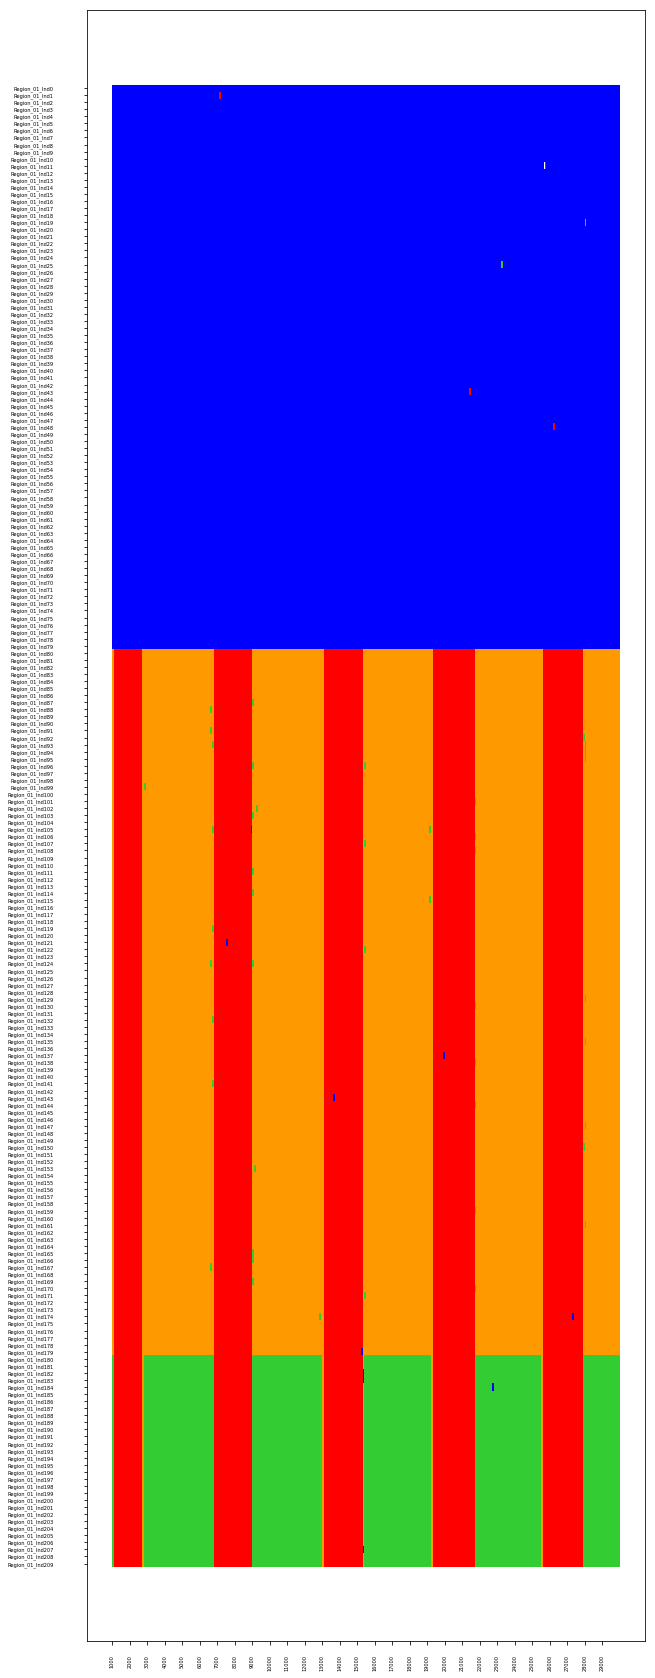

In [58]:
# Here's the function that we'll call for each dataframe (once for chromosome
# ideograms, once for genes).  The rest of this script will be prepping data
# for input to this function
#
def return_ideogram(ideo):
    # Height of each ideogram
    chrom_height = 1

    # Spacing between consecutive ideograms
    chrom_spacing = 0

    # Height of the gene track. Should be smaller than `chrom_spacing` in order to
    # fit correctly
    gene_height = 0.0

    # Padding between the top of a gene track and its corresponding ideogram
    gene_padding = 0.0


    # Keep track of the y positions for ideograms and genes for each chromosome,
    # and the center of each ideogram (which is where we'll put the ytick labels)
    ybase = 0
    chrom_ybase = {}
    gene_ybase = {}
    chrom_centers = {}

    # Iterate in reverse so that items in the beginning of `chromosome_list` will
    # appear at the top of the plot
    for chrom in chromosome_list[::-1]:
        chrom_ybase[chrom] = ybase
        chrom_centers[chrom] = ybase + chrom_height / 2.
        gene_ybase[chrom] = ybase - gene_height - gene_padding
        ybase += chrom_height + chrom_spacing



    # Keep track of the y positions for ideograms and genes for each chromosome,
    # and the center of each ideogram (which is where we'll put the ytick labels)
    ybase = 0
    chrom_ybase = {}
    gene_ybase = {}
    chrom_centers = {}

    # Iterate in reverse so that items in the beginning of `chromosome_list` will
    # appear at the top of the plot
    for chrom in chromosome_list[::-1]:
        chrom_ybase[chrom] = ybase
        chrom_centers[chrom] = ybase + chrom_height / 2.
        gene_ybase[chrom] = ybase - gene_height - gene_padding
        ybase += chrom_height + chrom_spacing
    

    # Colors for different chromosome stains
    color_lookup = {
        'red': [255, 0, 0],
        'yellow': [255, 255, 0],
        'blue': [0, 0, 255],
        'orange': [255, 165, 0],
        'green': [50, 205, 50],
        'black': [0, 0, 0],
        'purple': [128, 0, 128],
        'silver': [211, 211, 211],
    }

    # Add a new column for colors
    
    ideo['colors'] = ideo['gieStain'].apply(lambda x: tuple([round(y / float(255),1) for y in color_lookup[x]]))
    # Add a new column for width
    ideo['width'] = ideo.end - ideo.start

    # Width, height (in inches)
    figsize = (10, 30)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    # Now all we have to do is call our function for the ideogram data...
    print("adding ideograms...")
    for collection in chromosome_collections(ideo, chrom_ybase, chrom_height, edgecolors=None, linewidths= 0):
        ax.add_collection(collection)

    # Axes tweaking
    ax.set_xticks([x for x in range(min(ideo.start),max(ideo.end),int(1000))])
    plt.xticks(fontsize = 5,rotation = 90)
    ax.tick_params(axis = 'x',pad = 10)

    ax.tick_params(axis='y', which='major', pad=30)
    ax.set_yticks([chrom_centers[i] for i in chromosome_list])
    ax.set_yticklabels(chromosome_list, fontsize = 5)
    ax.axis('tight')
    return fig


fig= return_ideogram(ideo)


The resulting ideogram: samples classified according to the clusters they belonged to as X varied.

## Application

If we didn't know that the distances between two of the groups varied as a sinusoid of X, we might be interested in examining what exactly was going on with individuals assigned to profiles encompassing the two groups at those locations they were assigned to them.

In other contexts, location and extent of these assignments alone could be of interest.